# İçerik

# 1.Fashion Mnist
1. [Load Library](#ch0)
1. [Read Data](#ch1)
1. [Train Test Validation Split](#ch2)
1. [Normalization](#ch3)
1. [Convert Inputs for NNs](#ch4)
1. [Data Augmentations](#ch5)



# 2.Models
1. [Pipeline](#ch6)


# 3.Data Visualization
1. [Drawing](#ch9)
1. [Correct Results](#ch10)
1. [Uncorrect Results](#ch11)

<a id="ch0"></a>
# Load Library

In [2]:
import os
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import keras
import pickle


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline 

import sys
sys.path.insert(0,'..')
from utils import util, cv_models
from utils.random_eraser import get_random_eraser


# For faster calculation
#import keras.backend as K
#K.set_floatx('float16')
#K.set_epsilon(1e-4) 

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


<a id="ch1"></a>
# Read Data

In [3]:
data_train = pd.read_csv('../Data/fashion-mnist_train.csv')
data_test  = pd.read_csv('../Data/fashion-mnist_test.csv')

target_names = {0:"T-shirt/top",
                1:"Trouser",
                2:"Pullover",
                3:"Dress",
                4:"Coat",
                5:"Sandal",
                6:"Shirt",
                7:"Sneaker",
                8:"Bag",
                9:"Ankle boot"}

<a id="ch2"></a>
# Train Test Validation Split

In [18]:
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# Split train and validation data
#set random_state for reproduceable result
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)


#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_val   = X_val.astype('float32')


#get the indices to be plotted
y_test_true  = data_test.iloc[:, 0]
y_train_true = np.argmax(y_train, axis=1, out=None)

<a id="ch3"></a>
# Normalization

In [5]:
X_train /= 255
X_test  /= 255
X_val   /= 255

num_classes = len(np.unique(data_train.iloc[:, 0]))

<a id="ch4"></a>
# Convert Inputs For NNs

In [19]:
# Flat Input
X_train_flat = X_train
X_test_flat  = X_test
X_val_flat   = X_val

# 28x28 Images for simple CNN
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X_train28 = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test28  = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val28   = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# 32x32 Images for Deeper Architecture
X_train32 = util.resize_32x32(X_train)
X_val32   = util.resize_32x32(X_val)
X_test32  = util.resize_32x32(X_test)

<a id="ch5"></a>
# Data Augmentation and CallBacks

In [7]:
# Data Generator
datagen = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False, 
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=0,  
            zoom_range = 0.01,  
            width_shift_range=0,  
            height_shift_range=0,  
            horizontal_flip=True,  
            vertical_flip=False,)
            #preprocessing_function=get_random_eraser())


# CallBacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 

<a id="ch6"></a>
# Pipeline

In [10]:
import keras.backend as K
K.clear_session()
names = [#'mlp.h5',            \
         #'simpleCNN.h5',      \
         #'CNNDropout.h5',     \
         #'CNNBatchNorm.h5',   \
         #'simpleVGG.h5',      \
         #'simpleInception.h5', \
         #'simpleResnet.h5',   \
         'wideResnet.h5',     \
         'mobileNetV2.h5',    \
         #'Resnet50.h5',    \
         #'NASNet.h5'
        ]

flat  = ['mlp.h5']

inp28 = ['simpleCNN.h5',   \
         'CNNDropout.h5',  \
         'CNNBatchNorm.h5']

inp32 = ['Resnet50.h5', \
         'mobileNetV2.h5', \
         'wideResnet.h5', \
         'NASNet.h5', \
         'simpleVGG.h5',      \
         'simpleInception.h5',\
         'simpleResnet.h5' ]



models = [#cv_models.buildMLP(),
          #cv_models.buildSimpleCNN(),
          #cv_models.buildCNNDropout(),
          #cv_models.buildCNNBatchNorm(),
          #cv_models.buildSimpleVGG(),
          #cv_models.buildSimpleInception(),
          #cv_models.buildSimpleResnet(),
          cv_models.build_wide_resnet(16, 4),
          cv_models.buildMobileNetV2(),
          #cv_models.buildResNet50(),
          #cv_models.buildNASNet()
         ]

In [11]:
epochs   = 20
data_aug = False


test_pred_df  = pd.DataFrame()
train_pred_df = pd.DataFrame()
metrics_dict  = {}
history_dict  = {}


# train each model
for model, model_name in zip(models, names):
    if(model_name in flat):
        if(data_aug):
            continue
        else:
            X_train = X_train_flat
            X_test  = X_test_flat
            X_val   = X_val_flat   
            
    elif(model_name in inp28):
        X_train = X_train28
        X_test  = X_test28
        X_val   = X_val28
        
    elif(model_name in inp32):
        X_train = X_train32
        X_test  = X_test32
        X_val   = X_val32
        
    
    
    # Train and Save Results  
    print("----------------------------")
    if(data_aug):
        datagen.fit(X_train)
        history  = model.fit_generator(datagen.flow(X_train, y_train,batch_size=64),
                         steps_per_epoch=len(X_train) / 64,
                         epochs = epochs,
                         verbose=2,
                         validation_data=(X_val, y_val),
                         callbacks=[early, learning_rate_reduction])
        
    else:
        history  = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=20,
                     verbose=2,
                     validation_data=(X_val, y_val))
    
    # evulation
    score = model.evaluate(X_test, y_test, verbose=0)
    y_pred_test, metrics = util.get_pred_and_metrics(model,
                                                X_test,
                                                y_test_true,
                                                target_names)
    
    y_pred_train, metrics = util.get_pred_and_metrics(model,
                                                X_train,
                                                y_train_true,
                                                target_names)

    # Print model name and test accuracy score and loss
    print(model_name)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    
    # Save prediction for Stacking or Ensemble
    train_pred_df[model_name] = y_pred_train
    test_pred_df[model_name]  = y_pred_test
    
     
    # save model, plot model acc,loss and confussion matrix
    util.save_model(model, model_name)
    # save model deprecated --> save_prfs_and_modelHistory daha kompleks olarak aynı işi yapıyor
    
    model_name = model_name.split(".")[0]
    util.plot_accuracy_and_loss(history, model_name)
    util.plot_confussion_matrix(y_test_true, y_pred_test, target_names, model_name)
    
    
    # save history and prfs 
    metrics_dict[model_name]  = metrics
    history_dict[model_name]  = history
    util.save_prfs_and_modelHistory(data_aug, model_name, history, metrics)

----------------------------
Epoch 1/50
 - 60s - loss: 0.4558 - acc: 0.8339 - val_loss: 0.4279 - val_acc: 0.8481
Epoch 2/50
 - 57s - loss: 0.2881 - acc: 0.8962 - val_loss: 0.3561 - val_acc: 0.8780
Epoch 3/50
 - 57s - loss: 0.2442 - acc: 0.9128 - val_loss: 0.3145 - val_acc: 0.8887
Epoch 4/50
 - 57s - loss: 0.2203 - acc: 0.9211 - val_loss: 0.2792 - val_acc: 0.9012
Epoch 5/50
 - 57s - loss: 0.2058 - acc: 0.9255 - val_loss: 0.2903 - val_acc: 0.9025
Epoch 6/50
 - 57s - loss: 0.1904 - acc: 0.9313 - val_loss: 0.2917 - val_acc: 0.8938
Epoch 7/50
 - 57s - loss: 0.1769 - acc: 0.9347 - val_loss: 0.2377 - val_acc: 0.9121
Epoch 8/50
 - 57s - loss: 0.1650 - acc: 0.9400 - val_loss: 0.2255 - val_acc: 0.9216
Epoch 9/50
 - 57s - loss: 0.1524 - acc: 0.9455 - val_loss: 0.1962 - val_acc: 0.9317
Epoch 10/50
 - 57s - loss: 0.1439 - acc: 0.9474 - val_loss: 0.2127 - val_acc: 0.9250
Epoch 11/50
 - 57s - loss: 0.1305 - acc: 0.9520 - val_loss: 0.2279 - val_acc: 0.9223
Epoch 12/50
 - 57s - loss: 0.1186 - acc: 0.95

----------------------------
Epoch 1/50
 - 34s - loss: 0.7916 - acc: 0.7166 - val_loss: 2.6707 - val_acc: 0.6316
Epoch 2/50
 - 28s - loss: 0.4727 - acc: 0.8309 - val_loss: 6.2176 - val_acc: 0.5121
Epoch 3/50
 - 28s - loss: 0.4183 - acc: 0.8533 - val_loss: 3.2307 - val_acc: 0.6910
Epoch 4/50
 - 28s - loss: 0.4180 - acc: 0.8536 - val_loss: 4.9045 - val_acc: 0.6174
Epoch 5/50
 - 28s - loss: 0.3464 - acc: 0.8769 - val_loss: 1.0074 - val_acc: 0.8433
Epoch 6/50
 - 28s - loss: 0.3403 - acc: 0.8801 - val_loss: 2.5601 - val_acc: 0.7001
Epoch 7/50
 - 28s - loss: 0.3085 - acc: 0.8895 - val_loss: 1.2382 - val_acc: 0.8253
Epoch 8/50
 - 28s - loss: 0.2981 - acc: 0.8953 - val_loss: 1.1291 - val_acc: 0.8504
Epoch 9/50
 - 28s - loss: 0.3642 - acc: 0.8797 - val_loss: 10.9363 - val_acc: 0.2270
Epoch 10/50
 - 28s - loss: 0.6483 - acc: 0.8014 - val_loss: 11.1696 - val_acc: 0.1545
Epoch 11/50
 - 28s - loss: 0.7383 - acc: 0.7670 - val_loss: 5.0432 - val_acc: 0.4226
Epoch 12/50
 - 28s - loss: 0.4468 - acc: 0.

<a id="ch9"></a>
# Drawing

In [31]:
correct = np.nonzero(y_pred_test==y_test_true)[0]
incorrect = np.nonzero(y_pred_test!=y_test_true)[0]

/home/mustafa/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead



<a id="ch10"></a>
# Plot Correctly Classified

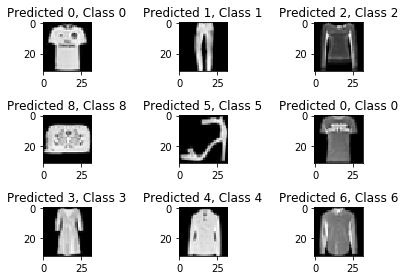

In [32]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test32[correct].reshape(32,32), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[correct], y_true[correct]))
    plt.tight_layout()

<a id="ch11"></a>
# Plot Incorrectly Classified

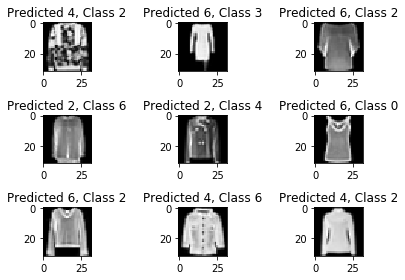

In [28]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test32[incorrect].reshape(32,32), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[incorrect], y_true[incorrect]))
    plt.tight_layout()